In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams["figure.figsize"] = (12, 6)
sns.set_style("whitegrid")


In [6]:
df = pd.read_csv("arima_data.csv")

df.head()


,Quarter,Revenue
0,Q1 - 2022,"13,597,078.35"
1,Q2 - 2022,"590,558,939.95"
2,Q3 - 2022,"1,938,021,172.98"
3,Q4 - 2022,"2,595,595,479.57"
4,Q1 - 2023,"18,174,750,874.9"


In [9]:
df.columns = df.columns.str.lower()

df["quarter"] = (
    df["quarter"]
    .str.replace(" ", "")
    .str.replace("-", "")
    .str.replace("Q1", "01")
    .str.replace("Q2", "04")
    .str.replace("Q3", "07")
    .str.replace("Q4", "10")
)

df["quarter"] = pd.to_datetime(df["quarter"], format="%m%Y")

df = df.sort_values("quarter")
df.set_index("quarter", inplace=True)

KeyError: 'quarter'

In [14]:
df

,revenue
quarter,
2022-01-01,"13,597,078.35"
2022-04-01,"590,558,939.95"
2022-07-01,"1,938,021,172.98"
2022-10-01,"2,595,595,479.57"
2023-01-01,"18,174,750,874.9"
2023-04-01,"38,139,430,855.3"
2023-07-01,"18,483,849,717.88"
2023-10-01,"42,907,295,517.14"
2024-01-01,"39,048,804,111.72"


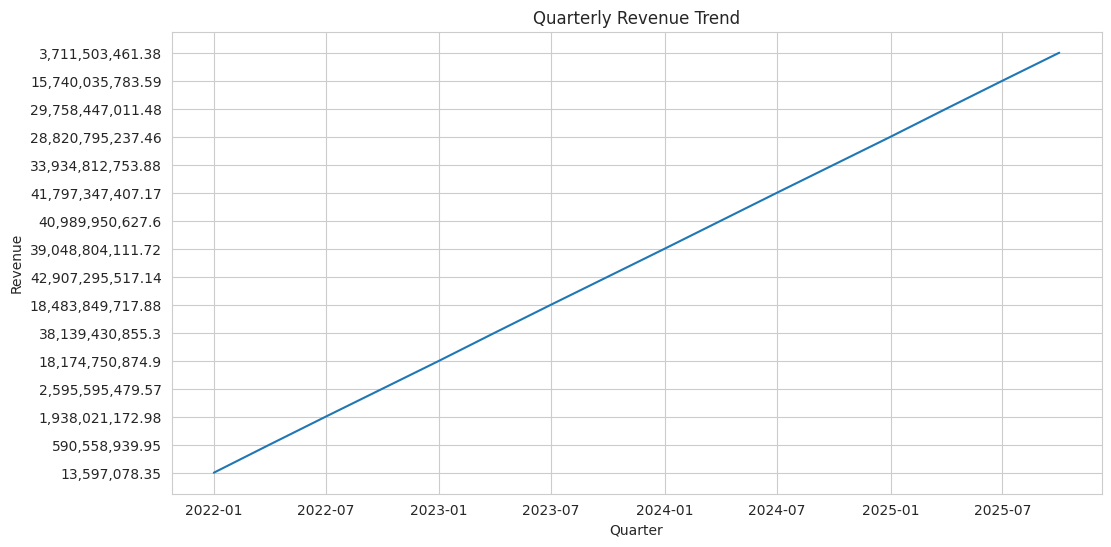

In [13]:
plt.plot(df.index, df["revenue"])
plt.title("Quarterly Revenue Trend")
plt.xlabel("Quarter")
plt.ylabel("Revenue")
plt.show()

In [15]:
#Growth volatility exist

In [19]:
df['revenue'].dtype

dtype('O')

In [20]:
df["revenue"] = (
    df["revenue"]
      .astype(str)
      .str.replace(",", "")
      .str.replace("₦", "")
      .str.strip()
)

df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")

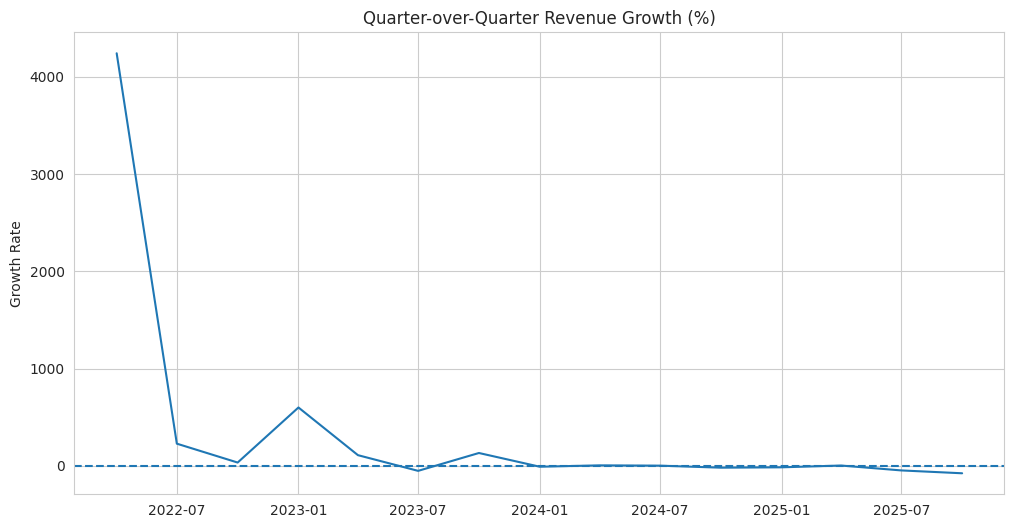

In [21]:
df["qoq_growth"] = df["revenue"].pct_change() * 100

plt.plot(df.index, df["qoq_growth"])
plt.axhline(0, linestyle="--")
plt.title("Quarter-over-Quarter Revenue Growth (%)")
plt.ylabel("Growth Rate")
plt.show()

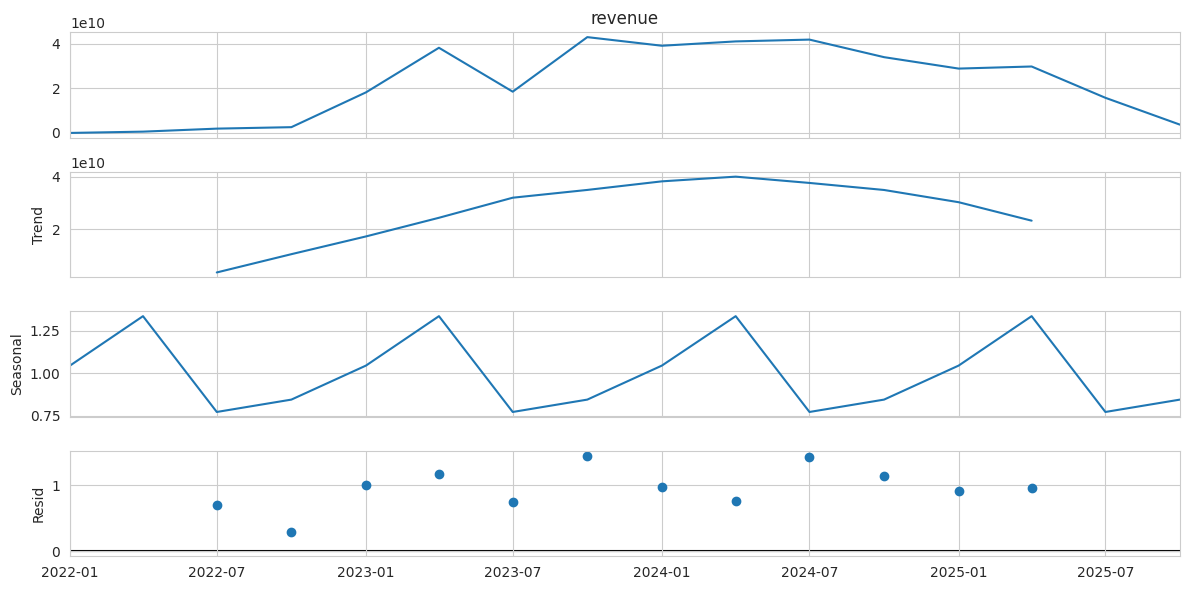

In [23]:
#seasonality

decomposition = seasonal_decompose(df["revenue"], model="multiplicative", period=4)
decomposition.plot()
plt.show()

In [24]:
#Checking for stationarity

adf_result = adfuller(df["revenue"])

print(f"ADF Statistic: {adf_result[0]}")
print(f"P-value: {adf_result[1]}")

ADF Statistic: -0.987415325981704
P-value: 0.7578265538280112


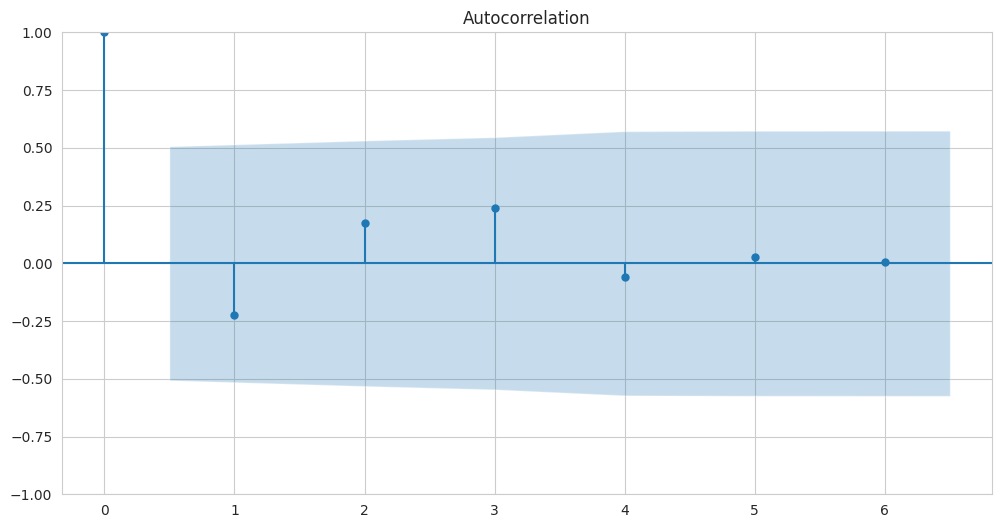

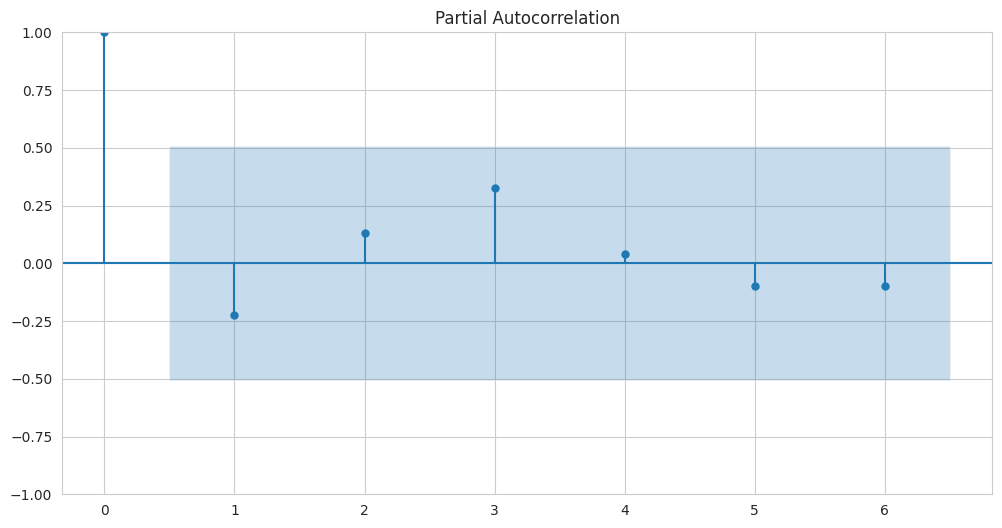

In [26]:
#applying autocorrection p = 0.75

plot_acf(df["revenue"].diff().dropna(), lags=6)
plt.show()

plot_pacf(df["revenue"].diff().dropna(), lags=6)
plt.show()

In [27]:
model = SARIMAX(
    df["revenue"],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 4),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           revenue   No. Observations:                   16
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -122.333
Date:                           Mon, 15 Dec 2025   AIC                            254.666
Time:                                   06:07:23   BIC                            252.713
Sample:                               01-01-2022   HQIC                           249.425
                                    - 10-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1686     18.702      0.009      0.993     -36.487      36.825
ma.L1          0.9889      2.779      0.356

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
#generate forecast

forecast = results.get_forecast(steps=4)
forecast_ci = forecast.conf_int()

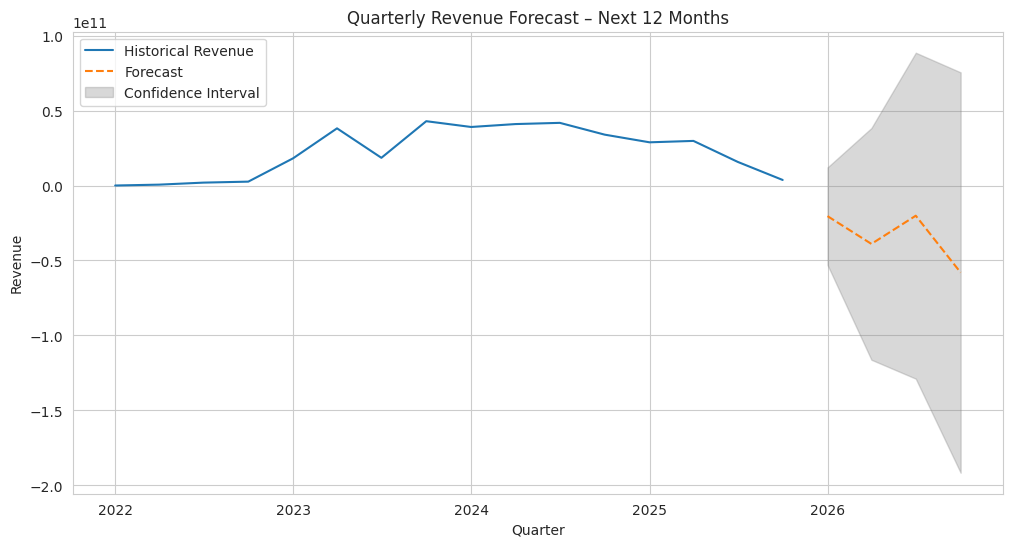

In [31]:
plt.plot(df.index, df["revenue"], label="Historical Revenue")
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label="Forecast", linestyle="--")

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="gray",
    alpha=0.3,
    label="Confidence Interval"
)

plt.title("Quarterly Revenue Forecast – Next 12 Months")
plt.xlabel("Quarter")
plt.ylabel("Revenue")
plt.legend()
plt.savefig("quarterly_revenue_forecast.png", dpi=300, bbox_inches="tight")
plt.show()

In [30]:
forecast_df = pd.DataFrame({
    "Quarter": forecast.predicted_mean.index,
    "Expected_Revenue": forecast.predicted_mean.values,
    "Lower_Bound": forecast_ci.iloc[:, 0].values,
    "Upper_Bound": forecast_ci.iloc[:, 1].values
})

forecast_df


,Quarter,Expected_Revenue,Lower_Bound,Upper_Bound
0,2026-01-01,-2.041479e+10,-5.290900e+10,1.207941e+10
1,2026-04-01,-3.893071e+10,-1.162019e+11,3.834051e+10
2,2026-07-01,-2.012411e+10,-1.288221e+11,8.857388e+10
3,2026-10-01,-5.803393e+10,-1.915416e+11,7.547375e+10
